## Example Program

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns 
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import torch
from Yolo.detect_face import get_faces_bbox
from Yolo.models.experimental import attempt_load

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [3]:
input_data_path = 'images'
annotations_path = "annotations"
images = [*os.listdir("images")]

dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [5]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [7]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73
5,maksssksksss1,400,156,3,with_mask,299,58,315,81
6,maksssksksss1,400,156,3,with_mask,143,74,174,115
7,maksssksksss1,400,156,3,with_mask,74,69,95,99


with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

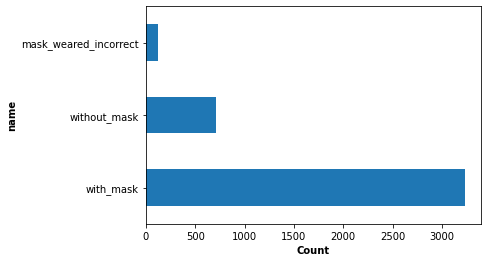

In [10]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')
df["name"].value_counts()

In [13]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [14]:
cropped_faces = [extract_faces(img, df) for img in images]

In [15]:
flat_cropped_faces = sum(cropped_faces, [])

In [16]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [21]:
SPLIT_FOLDER_SIZE = 0.2

## Create train and test folders
dataset_img_dir = 'Dataset/images'
dir_name = ['with_mask', 'incorrect_mask', 'without_mask']

for subsplit in ['train', 'test']:
    for d in dir_name:
        path = os.path.join(dataset_img_dir, subsplit, d)
        if not os.path.exists(path):
            os.makedirs(path)


train_with_mask, test_with_mask = train_test_split(with_mask, test_size = SPLIT_FOLDER_SIZE)
for image, image_name in train_with_mask:
    image.save(f"Dataset/images/train/with_mask/{image_name}.png")
for image, image_name in test_with_mask:
    image.save(f"Dataset/images/test/with_mask/{image_name}.png")
    

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size = SPLIT_FOLDER_SIZE)
for image, image_name in train_mask_weared_incorrect:
    image.save(f"Dataset/images/train/incorrect_mask/{image_name}.png")
for image, image_name in test_mask_weared_incorrect:
    image.save(f"Dataset/images/test/incorrect_mask/{image_name}.png")

train_without_mask, test_without_mask = train_test_split(without_mask, test_size = SPLIT_FOLDER_SIZE)
for image, image_name in train_without_mask:
    image.save(f"Dataset/images/train/without_mask/{image_name}.png")
for image, image_name in test_without_mask:
    image.save(f"Dataset/images/test/without_mask/{image_name}.png")

## Tensorflow Load Data

In [15]:
TRAIN_DIR = "Dataset/images/train"
TEST_DIR = "Dataset/images/test"
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=90,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       zoom_range=0.4,
                                       horizontal_flip=True,
                                       fill_mode='nearest',
                                       validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        color_mode='grayscale',
                                                        target_size=(64, 64),
                                                        subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical',
                                                            color_mode='grayscale',
                                                            target_size=(64, 64),
                                                            subset='validation')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    color_mode='grayscale',
                                                    shuffle = False,
                                                    target_size=(64, 64))

Found 2605 images belonging to 3 classes.
Found 649 images belonging to 3 classes.
Found 815 images belonging to 3 classes.


## Create Model

In [16]:
## Test 1
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (64,64,1)))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.Flatten())
model.add(layers.Dense(units = 512, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units = 3, activation = 'softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(epoch>5):
            accuracy = logs.get('acc') if logs.get('acc') != None else logs.get('accuracy')
            val_accuracy = logs.get('val_acc') if logs.get('val_acc') != None else logs.get('val_accuracy')
            
            if (accuracy > 0.85) and (val_accuracy > 0.85):
                print("\nReached 85% accuracy so cancelling training!")
                self.model.stop_training = True
    
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
            myCallback()]

history_train = model.fit(train_generator,validation_data=validation_generator,epochs=100,verbose=1,callbacks=callbacks)

Epoch 1/100
82/82 [==============================] - 23s 219ms/step - loss: 0.6032 - acc: 0.7939 - val_loss: 0.5710 - val_acc: 0.7951
Epoch 2/100
82/82 [==============================] - 4s 48ms/step - loss: 0.5698 - acc: 0.7939 - val_loss: 0.5703 - val_acc: 0.7951
Epoch 3/100
82/82 [==============================] - 4s 50ms/step - loss: 0.5580 - acc: 0.7935 - val_loss: 0.5330 - val_acc: 0.7951
Epoch 4/100
82/82 [==============================] - 4s 45ms/step - loss: 0.5458 - acc: 0.7950 - val_loss: 0.5778 - val_acc: 0.7951
Epoch 5/100
82/82 [==============================] - 3s 40ms/step - loss: 0.5376 - acc: 0.7992 - val_loss: 0.5355 - val_acc: 0.7966
Epoch 6/100
82/82 [==============================] - 3s 39ms/step - loss: 0.5362 - acc: 0.8061 - val_loss: 0.5395 - val_acc: 0.7982
Epoch 7/100
82/82 [==============================] - 3s 39ms/step - loss: 0.5205 - acc: 0.8054 - val_loss: 0.5234 - val_acc: 0.7951
Epoch 8/100
82/82 [==============================] - 3s 42ms/step - loss: 

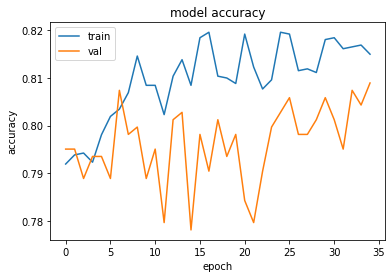

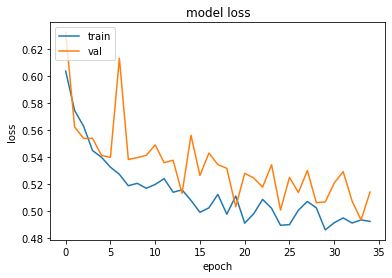

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_train.history['acc'])
plt.plot(history_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Eval

In [10]:
def Num2Label(num):
    if num == 0:
        return "incorrect_mask"
    elif num == 1:
        return "with_mask"
    else:
        return "without_mask"

In [11]:
def getAktualFromGen(generator,b_size):
    number_of_examples = len(generator.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * b_size)) 
    labels = []

    for i in range(0,int(number_of_generator_calls)):
        labels.extend(np.array(generator[i][1]))
    return labels

### Train

In [12]:
## Aktual
train_aktual = np.argmax(getAktualFromGen(train_generator,BATCH_SIZE), axis=1)

## Predictions
train_pred = model.predict(train_generator)
y_train = np.argmax(train_pred, axis=1)

82/82 [==============================] - 3s 34ms/step


In [13]:
confusion_matrix(train_aktual, y_train)

array([[   0,   70,    9],
       [   0, 1984,   84],
       [   0,  320,  138]], dtype=int64)

In [14]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_train, train_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.96      0.84      0.89      2374
  without_mask       0.30      0.60      0.40       231

      accuracy                           0.81      2605
     macro avg       0.42      0.48      0.43      2605
  weighted avg       0.90      0.81      0.85      2605



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### validation

In [15]:
## Aktual
val_aktual = np.argmax(getAktualFromGen(validation_generator,BATCH_SIZE), axis=1)

## Predictions
val_pred = model.predict(validation_generator)
y_val = np.argmax(val_pred, axis=1)

21/21 [==============================] - 1s 45ms/step


In [16]:
confusion_matrix(val_aktual, y_val)

array([[  0,  17,   2],
       [  0, 503,  13],
       [  0,  97,  17]], dtype=int64)

In [17]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_val, val_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.97      0.82      0.89       617
  without_mask       0.15      0.53      0.23        32

      accuracy                           0.80       649
     macro avg       0.37      0.45      0.37       649
  weighted avg       0.93      0.80      0.86       649



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Test

In [18]:
## Aktual
test_aktual = np.argmax(getAktualFromGen(test_generator,1), axis=1)

## Predictions
test_pred = model.predict(test_generator)
y_test = np.argmax(test_pred, axis=1)

815/815 [==============================] - 2s 3ms/step


In [19]:
confusion_matrix(test_aktual, y_test)

array([[  0,  22,   3],
       [  0, 634,  13],
       [  0,  95,  48]], dtype=int64)

In [20]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_test, test_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.98      0.84      0.91       751
  without_mask       0.34      0.75      0.46        64

      accuracy                           0.84       815
     macro avg       0.44      0.53      0.46       815
  weighted avg       0.93      0.84      0.87       815



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Mediapipe Annotation

In [6]:
def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def Num2Label(num):
    if num == 0:
        return "incorrect_mask",(255, 255, 0)
    elif num == 1:
        return "with_mask",(0, 255, 0)
    elif num == 2:
        return "without_mask",(0, 0, 255)
    else:
        raise ValueError("Invalid number")

Fusing layers... 
3 faces


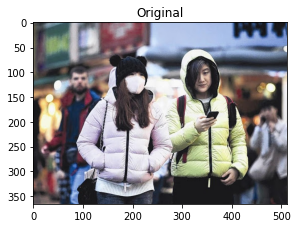

[313.0, 78.0, 363.0, 141.0]
1/1 [==============================] - 0s 81ms/step
[76.0, 99.0, 112.0, 140.0]
1/1 [==============================] - 0s 26ms/step
[181.0, 92.0, 229.0, 145.0]
1/1 [==============================] - 0s 22ms/step


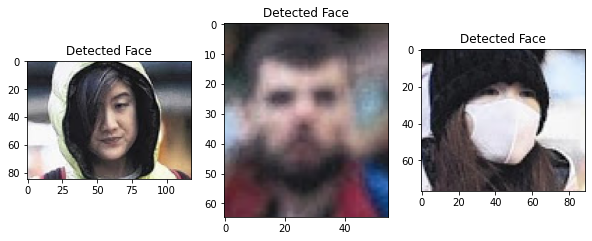

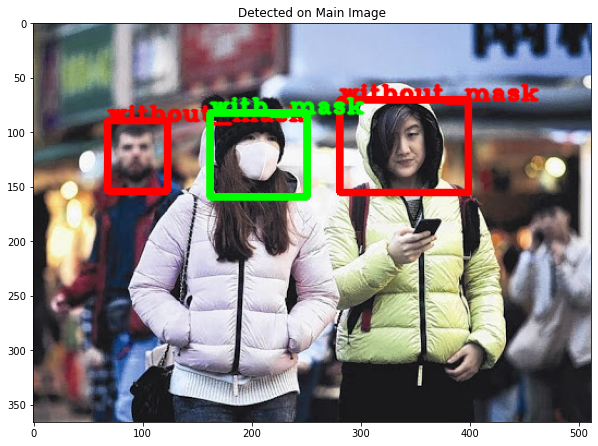

In [10]:
pred_file = "D:/Andre/Pemrograman/Github/Face Mask/images/maksssksksss0.png"

%matplotlib inline 
plt.figure(figsize=(10,10))
plt.subplot(121)
image = cv2.imread(pred_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = attempt_load('Yolo/yolov5m-face.pt', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")) 
faces = get_faces_bbox(image,yolo_model,device)
height, width, colors = image.shape

plt.imshow(BGR2RGB(image))
plt.title("Original")

plt.show()
plt.figure(figsize=(10,10))

annotated_img = image.copy()
mask_model = tf.keras.models.load_model('cnn_model.h5')
for idx,face in enumerate(faces):
    plt.subplot(1,3,idx+1)
    rgb_im = BGR2RGB(image)

    print(face)
    tolerance = 0.1
    face_start_point = int(face[0]*(1-tolerance)),int(face[1]*(1-tolerance))
    face_end_point = int(face[2]*(1+tolerance)),int(face[3]*(1+tolerance))
    cropped_image = rgb_im[face_start_point[1]:face_end_point[1],face_start_point[0]:face_end_point[0]]
    plt.imshow(cropped_image)
    plt.title("Detected Face")


    pred_image = tf.image.resize(cropped_image, [128,128], method=tf.image.ResizeMethod.BICUBIC)
    pred_image = pred_image/255.0
    pred_image = tf.expand_dims(pred_image, axis=0)
    pred = np.argmax(mask_model.predict(pred_image), axis=1)

    label,color = Num2Label(pred[0])
    cv2.rectangle(annotated_img, face_start_point, face_end_point, color, 5)
    cv2.putText(annotated_img, label, face_start_point, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, color, 2, cv2.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(BGR2RGB(annotated_img))
plt.title("Detected on Main Image")
plt.show()